In [1]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import tempo, util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

# create the universe
uni_config = godot.cosmos.util.load_yaml('universe2.yml')
uni = godot.cosmos.Universe(uni_config)

In [2]:
year = 2027
filename = 'one_year_' + str(year) + '.pickle'
with open(filename, 'rb') as f:
    res = pickle.load(f)

In [3]:
with open("/home/es820/Documents/GODOTWork/CB11_elevations.pickle", 'rb') as f:
    elevold = pickle.load(f)

In [4]:
print('loaded!')
e = res.elv('NN11')
print(type(e.values))

loaded!
<class 'numpy.ndarray'>


In [23]:
import mani_rain
from mani.StateEvaluator import SEEnum
condition = res.above_elev('NN11', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])
elevations = res.df.loc[condition]['NN11']
print(len(condition))
print(60*60*24*365)
print(86400*365.2524)

31536001
31536000
31557807.360000003


In [ ]:
from mani.utils import 

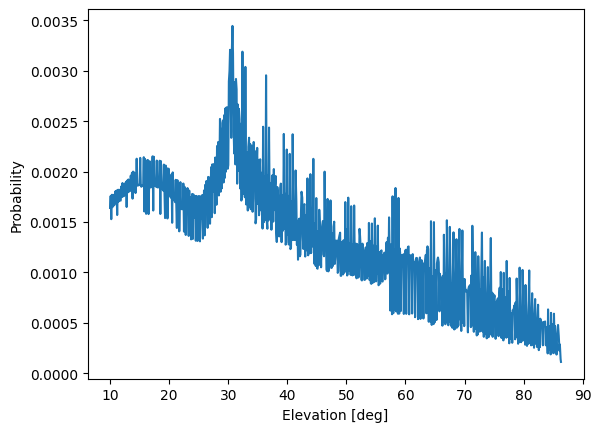

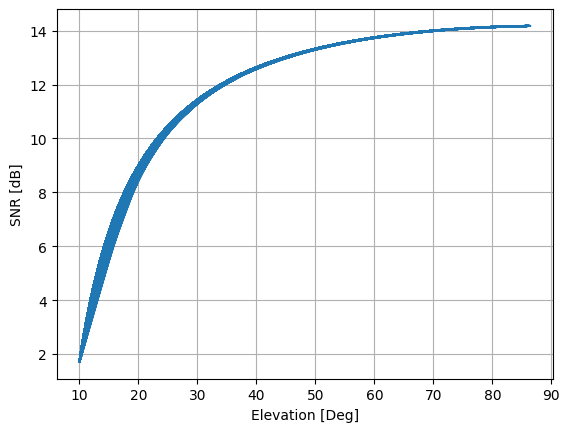

In [ ]:
with open('./output/NN11_elevations.pickle', 'wb') as f:
    pickle.dump(elevations, f, protocol=pickle.HIGHEST_PROTOCOL)

nn = mani_rain.new_norcia
nn.gen_el_dist(file='/home/es820/Documents/GODOTWork/output/NN11_elevations.pickle')

plt.figure()
plt.plot(*nn.el_distribution)
plt.xlabel("Elevation [deg]")
plt.ylabel("Probability")
plt.show()

link = mani_rain.link_budget_itu(nn, 100e6)
dist = 384400e3
rain_rate = 4 #mmhr⁻¹
rain_rates = np.full(len(elevations), rain_rate)
snr_list = []
for idx, el in enumerate(elevations):
    snr_list.append(link.snr_at_t(dist, el, rain_rates[idx]))
plt.figure()
plt.plot(elevations, snr_list)
plt.grid()
plt.xlabel("Elevation [Deg]")
plt.ylabel("SNR [dB]")
plt.show()